In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import json
import fitsio
import pandas as pd
import time
import pickle
import re

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.coreRL.offline_dataset import OfflineDECamDataset
from survey_ops.coreRL.agents import Agent
from survey_ops.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.sys_utils import seed_everything
from survey_ops.coreRL.data_loading import load_raw_data_to_dataframe


In [3]:
from survey_ops.utils import ephemerides
from tqdm import tqdm
from pathlib import Path

In [4]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [5]:
with open('../configs/global_config.json', 'r') as f:
    glob_cfg = json.load(f)

In [97]:
with open('../experiment_results/bc-radec-best/config.json', 'r') as f:
    cfg = json.load(f)

In [98]:
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NVISITS'], 'r') as f:
#     field2nvisits = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NAME'], 'r') as f:
#     field2name = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2RADEC'], 'r') as f:
#     field2radec = json.load(f)
with open('../data/lookups/nside16_bin2fields_in_bin.json', 'r') as file:
    data = json.load(file)

In [99]:
# fits_path = Path(cfg.get('paths.DFITS')).resolve().parents[1] / 'data' / cfg.get('paths.DFITS')
# json_path = Path(cfg.get('paths.DJSON')).resolve().parents[1] / 'data' / cfg.get('paths.DJSON')

df = load_raw_data_to_dataframe(fits_path=None, json_path='../data/decam-exposures-20251211.json')


In [100]:
cfg['data']['specific_years'] = None
cfg['data']['specific_months'] = None
cfg['data']['specific_days'] = None
cfg['data']['include_bin_features'] = False

In [101]:
dataset = OfflineDECamDataset(
    df=df,
    cfg=cfg,
    glob_cfg=glob_cfg,
)

Calculating zenith states: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:03<00:00, 193.19it/s]


(array([ 4984.,  5797.,  3493.,  3692.,  8819.,  6962., 10287., 11263.,
        15895., 11837.]),
 array([1376. , 1535.2, 1694.4, 1853.6, 2012.8, 2172. , 2331.2, 2490.4,
        2649.6, 2808.8, 2968. ]),
 <BarContainer object of 10 artists>)

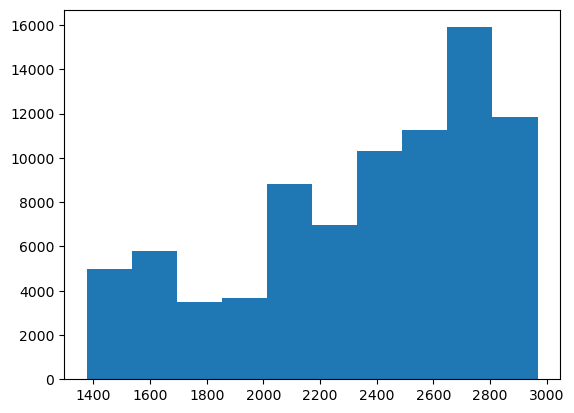

In [104]:
plt.hist(dataset._df['bin'].values)

In [106]:
from survey_ops.algorithms import setup_algorithm

In [117]:
hpGrid = ephemerides.HealpixGrid(nside=16, is_azel=True)

In [114]:
algorithm = setup_algorithm(save_dir='./', algorithm_name=cfg['model']['algorithm'], 
                            obs_dim=cfg['data']['obs_dim'], num_actions=cfg['data']['num_actions'], loss_fxn=cfg['model']['loss_function'],
                            hidden_dim=cfg['train']['hidden_dim'], lr=cfg['train']['lr'], lr_scheduler=cfg['train']['lr_scheduler'], 
                            device=device, lr_scheduler_kwargs=cfg['train']['lr_scheduler_kwargs'], lr_scheduler_epoch_start=cfg['train']['lr_scheduler_epoch_start'], 
                            lr_scheduler_num_epochs=cfg['train']['lr_scheduler_num_epochs'], gamma=cfg['model']['gamma'], 
                            tau=cfg['model']['tau'], activation=cfg['model']['activation'])

agent = Agent(
    algorithm=algorithm,
    train_outdir=cfg['metadata']['outdir'],
)
agent.load(cfg['metadata']['outdir'] + '/best_weights.pt')

In [124]:
# Plot predicted action for each state
with torch.no_grad():
    logits = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(logits, dim=1).to('cpu').detach().numpy()

    print(f"Logit stats: min={logits.min():.3f}, max={logits.max():.3f}, std={logits.std():.3f}")
    print(f"Top 5 logits: {logits.topk(5).values}")
    print(f"Top 5 bins: {logits.topk(5).indices}")

Logit stats: min=-81.935, max=26.222, std=7.402
Top 5 logits: tensor([[15.1552, 14.7649, 14.6848, 13.7786, 13.6647],
        [15.6249, 14.4760, 13.9208, 13.3328, 10.7754],
        [15.5354, 14.8340, 14.1434, 13.6398, 10.9726],
        ...,
        [16.6363, 16.2339, 15.4044, 15.3274, 14.9412],
        [17.4990, 17.4154, 16.5941, 15.6600, 15.6007],
        [18.4236, 17.8687, 17.2216, 16.5209, 15.5087]], device='cuda:0')
Top 5 bins: tensor([[1562, 2844, 1561, 1500, 2644],
        [2754, 2845, 2700, 2885, 2756],
        [2754, 2845, 2700, 2885, 2886],
        ...,
        [2158, 2159, 2349, 2095, 2094],
        [2158, 2159, 2095, 2094, 2349],
        [2606, 2665, 2544, 2542, 2664]], device='cuda:0')


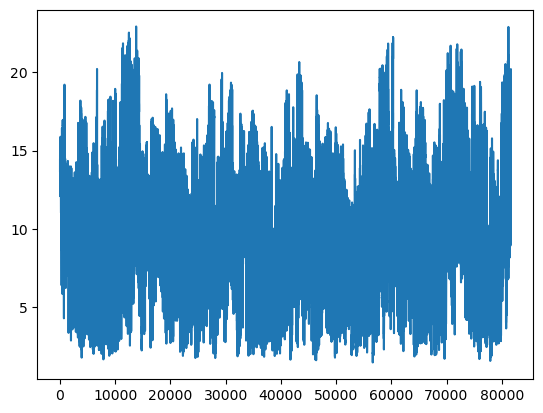

In [135]:
plt.plot(logits.topk(5).values.mean(axis=1).cpu().detach().numpy())

In [39]:
hpGrid = ephemerides.HealpixGrid(nside=16, is_azel=False)

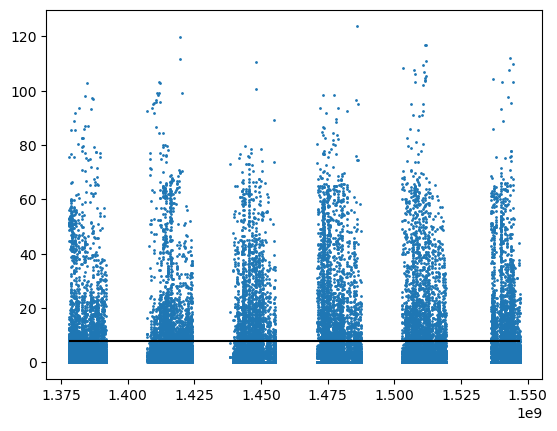

In [67]:
radec = np.array((df['ra'].values, df['dec'].values))*units.deg
pos1 = radec[:, :-1]
pos2 = radec[:, 1:]
ang_seps = geometry.angular_separation(pos1=pos1, pos2=pos2)
plt.scatter(df['timestamp'].values[1:], ang_seps/units.deg, s=1)
plt.hlines(y=.14/units.deg, xmin=np.min(df['timestamp']), xmax=np.max(df['timestamp']), color='black')

In [60]:
len(ang_seps[ang_seps < .04]) / len(ang_seps)

0.6520216851140728

In [64]:
.075 / units.deg

4.297183463481174

In [57]:
np.mean(ang_seps)

np.float64(0.07816551346883441)

In [41]:
lonlat = np.array((hpGrid.lon, hpGrid.lat))

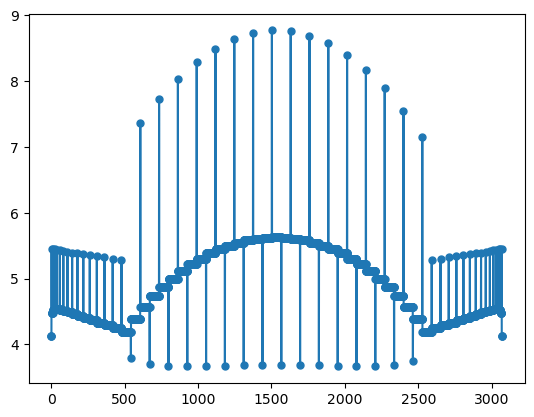

In [65]:
pos1 = lonlat[:, :-1]
pos2 = lonlat[:, 1:]
ang_seps = geometry.angular_separation(pos1=pos1, pos2=pos2)
plt.plot(ang_seps/units.deg, marker='o', markersize=5)


In [125]:
probabilities = F.softmax(logits, dim=1)

0        301.199042
1        300.851117
2        300.460079
3        300.016742
4        302.722079
            ...    
88613     58.930033
88614     58.929917
88615     53.414579
88616     53.389708
88617     53.389546
Name: ra, Length: 88618, dtype: float64

In [20]:
cfg['data']['specific_years'] = [2018]

In [21]:
train_dataset = OfflineDECamDataset(
    df,
    cfg=cfg,
    glob_cfg=glob_cfg
)

Calculating zenith states: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 757.21it/s]
Calculating bin features for all healpix bins and timestamps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11805/11805 [01:27<00:00, 134.65it/s]
Normalizing bin features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18432/18432 [00:01<00:00, 16228.18it/s]


In [24]:
train_dataset

In [71]:
n_nights = train_dataset._df.groupby('night').ngroups

In [94]:
df['bins_visited_in_night'] = 0

In [107]:
pd.Grouper

pandas.core.groupby.grouper.Grouper

In [ ]:
# Requirements:
    # Bins with incomplete fields
    # Bins are above horizon

In [113]:
train_dataset.hpGrid.is_azel

False

In [120]:
hpGrid = ephemerides.HealpixGrid(nside=16, is_azel=True)

In [ ]:
bin2fiel

In [ ]:
# Env
    def _get_azel_action_mask(self, timestamp):
        """
        Returns action_mask which masks bins that are invalid; ie bins that are below horizon or bins that contain completely observed fields (defined by field2nvisits)
        """
        incomplete_fields_mask = np.array([self._visited.count(fid) < self.field2nvisits[fid] for fid in self.field_ids])
        fields_az, fields_el = ephemerides.equatorial_to_topographic(ra=self.field_radecs[incomplete_fields_mask, 0], dec=self.field_radecs[incomplete_fields_mask, 1], time=timestamp)
        field_bins = self.hpGrid.ang2idx(lon=fields_az, lat=fields_el) # returns None if (az, el) below horizon
        field_bins = field_bins[field_bins != None].astype(np.int32)
        action_mask = np.zeros(shape=self.nbins, dtype=bool)
        action_mask[field_bins] = True

        return action_mask

    def _get_radec_action_mask(self, action, timestamp=None):
        _, bin_els = ephemerides.equatorial_to_topographic(ra=self.hpGrid.lon, dec=self.hpGrid.lat, time=timestamp)
        mask_below_horizon = bin_els >= 0

        # For initial zenith state in environment
        if action is not None: # action is None only in self._init_to_first_state()
            fields_in_bin = get_fields_in_radec_bin(bin_num=action, bin2fields_in_bin=self.bin2fields_in_bin)
            for i, field_id in enumerate(fields_in_bin):
                max_nvisits = self.field2nvisits[field_id]
                current_nvisits = self._visited.count(field_id)
                assert not current_nvisits > max_nvisits, "Number of field visits should never be greater than max number of allowed visits"
                if current_nvisits < max_nvisits:
                    break
                else:
                    if i == len(fields_in_bin) - 1:
                        self._mask_completed_bins[action] = False
        action_mask = mask_below_horizon & self._mask_completed_bins
        return action_mask

# survey_logic (agent)
def get_fields_in_azel_bin(bin_num, timestamp, field2nvisits, field_ids, field_radecs, hpGrid, visited, bin2fields_in_bin=None):
    mask_completed_fields = np.array([visited.count(fid) < field2nvisits[fid] for fid in field_ids])
    fields_az, fields_el = ephemerides.equatorial_to_topographic(ra=field_radecs[:, 0], dec=field_radecs[:, 1], time=timestamp)
    field_bins = hpGrid.ang2idx(lon=fields_az, lat=fields_el)
    # valid fields are fields in bin and fields which have not been completed
    mask_below_horizon = field_bins != None
    mask_invalid_fields = (field_bins == bin_num) & mask_completed_fields & mask_below_horizon
    fields_in_bin = field_ids[mask_invalid_fields]
    # return field_bins, incomplete_fields_mask
    return fields_in_bin

def get_fields_in_radec_bin(bin_num, bin2fields_in_bin, timestamp=None, field2nvisits=None, field_ids=None, field_radecs=None, hpGrid=None, visited=None):
    bin_num = str(bin_num)
    fields_in_bin = bin2fields_in_bin.get(bin_num)
    sel_valid_fields = [visited.count(fid) < field2nvisits[fid] for fid in field_in_bin]
    return fields_in_bin[sel_valid_fields]


In [ ]:
def get_action_mask(bin_num, bin_space, timestamp, field2nvisits, field_ids, field_radecs, hpGrid, visited, bin2fields_in_bin=None)
    # Mask fields which are completed 
    mask_completed_fields = np.array([visited.count(fid) < field2nvisits[fid] for fid in field_ids], dtype=bool)
    fields_az, fields_el = ephemerides.equatorial_to_topographic(ra=field_radecs[mask_completed_fields, 0], dec=field_radecs[mask_completed_fields, 1], time=timestamp)
    # Mask fields below horizon
    mask_fields_below_horizon = fields_el < 0
    # Get bins which are below horizon, masking completed bins
    field_bins = self.hpGrid.ang2idx(lon=fields_az[mask_fields_below_horizon], lat=fields_el[mask_fields_below_horizon])
    field_bins = field_bins[field_bins != None].astype(np.int32) # if in azel space, if bin center is below horizon, returns None
    # Construct action mask
    action_mask = np.zeros(shape=self.nbins, dtype=bool)
    action_mask[field_bins] = True
    return action_mask

In [ ]:
def get_fields_in_bin(bin_num ,timestamp, field2nvisits, field_ids, field_radecs, hpGrid, visited, bin2fields_in_bin):
    

In [102]:
train_dataset._df['bins_visited_in_night'] = train_dataset._df.groupby('night').apply(add_bin_visits_to_group).reset_index(level=0, drop=True)

/tmp/ipykernel_13665/1939545460.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_dataset._df['bins_visited_in_night'] = train_dataset._df.groupby('night').apply(add_bin_visits_to_group).reset_index(level=0, drop=True)


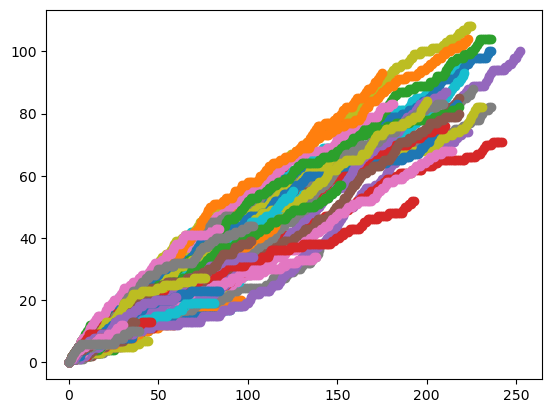

In [106]:
for night, group in train_dataset._df.groupby('night'):
    plt.plot(group['bins_visited_in_night'].values, marker='o')

In [81]:
train_dataset._df['']

11707   2018-01-03
0       2018-01-03
1       2018-01-03
2       2018-01-03
3       2018-01-03
           ...    
11702   2018-12-30
11703   2018-12-30
11704   2018-12-30
11705   2018-12-30
11706   2018-12-30
Name: night, Length: 11805, dtype: datetime64[ns]

In [68]:
for night, group in tqdm(train_dataset._df.groupby('night'), total=n_nights):
    bin_history = []
    for i_row in range(len(group)):
        if row['object'] == 'zenith':
            continue
        bin_history.append(row['bin'])
        num_bins = len(set(bin_history))
        group.iloc[i_row]['bins_visited_in_night'] = num_bins
    break

  0%|                                                                                                                                                                                                                                                                                                  | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_13665/1574693581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.iloc[i_row]['bins_visited_in_night'] = num_bins
/tmp/ipykernel_13665/1574693581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.iloc[i_row]['bins_visited_in_night'] = num_bins
/tmp/ipykernel_13665/1574693581.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
